# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## 루브릭

|평가문항|상세기준|
|:--|:--|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

In [ ]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-03-27 19:50:48--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-03-27 19:50:48--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1fd3ecaeedf3dc67270d469ff0.dl.dropboxusercontent.com/cd/0/get/BiTYv8VN5cc1Ki2aoe2IhoeK1Tb8RbMGeXm1rPcO1oeI-IFl-9Dt9tlzFsjaz9RMfsgSJ1gSP11DXNVbexlXCQKvss5tmvzyDev5DKBED5tgJFhowPkVH4t-LnITFXZ6Bzpcxszv_1UQMKLX78OzOzMPrAUE6usaT_fJCjRmeTK7qKI8ACYuzhha432NVXyTly0/file?dl=1# [following]
--2022-03-27 19:50:49--  https://uc1fd3ecaeedf3dc67270d469ff0.dl.dropboxusercontent.com/cd/0/g

# 필요한 라이브러리 import

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from konlpy.tag import Mecab

# 데이터 불러오기 및 전처리

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fad4c755890>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data))  # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data))  # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
# 전처리

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')

test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "") 
test_data['document'].replace('', np.nan, inplace=True) 
test_data = test_data.dropna(how = 'any')

In [ ]:
print('train_data 전처리 후 리뷰 개수:', len(train_data))
print('test_data 전처리 후 리뷰 개수:', len(test_data))

train_data 전처리 후 리뷰 개수: 145393
test_data 전처리 후 리뷰 개수: 48852


Data Size: 143620
문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


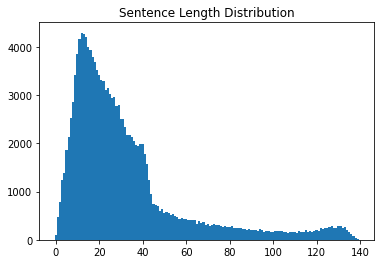

In [ ]:
min_len = 999
max_len = 0
sum_len = 0
raw = train_data['document']

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

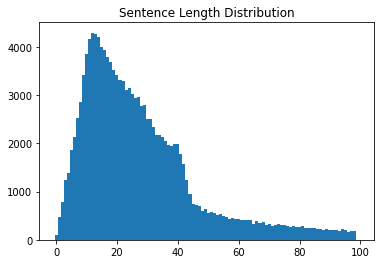

In [ ]:
max_len = 100
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# SentencPiece 적용

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 14.7 MB/s 


```bash
$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ mkdir -p ~/aiffel/sp_tokenizer/data
$ mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
$ cd ~/aiffel/sp_tokenizer/data
$ tar -xzvf korean-english-park.train.tar.gz
```

## Sentencepiece unigram

In [ ]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=navermovie_korean_spm_8000_unigram --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l navermovie_korean_spm_8000_unigram*

-rw-r--r-- 1 root root 378458 Mar 27 19:52 navermovie_korean_spm_8000_unigram.model
-rw-r--r-- 1 root root 147896 Mar 27 19:52 navermovie_korean_spm_8000_unigram.vocab


## Sentencepiece BPE(Byte Pair Encoding)

In [ ]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=navermovie_korean_spm_8000_bpe --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l navermovie_korean_spm_8000_bpe*

-rw-r--r-- 1 root root 373680 Mar 27 19:52 navermovie_korean_spm_8000_bpe.model
-rw-r--r-- 1 root root 118868 Mar 27 19:52 navermovie_korean_spm_8000_bpe.vocab


# 학습된 모델로 sp_tokenize() 메소드 구현

## 8000_unigram

In [ ]:
def sp_tokenize_8000_unigram(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./navermovie_korean_spm_8000_unigram.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')  # 패딩

    return tensor, word_index, index_word

## 8000_bpe

In [ ]:
def sp_tokenize_8000_bpe(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./navermovie_korean_spm_8000_bpe.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')  # 패딩

    return tensor, word_index, index_word

# 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습

## 데이터 로더 구성

### 8000_unigram

In [ ]:
s_unigram = spm.SentencePieceProcessor()
s_unigram.Load('navermovie_korean_spm_8000_unigram.model')

True

In [ ]:
def load_data_8000_unigram(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # train 데이터 토큰화
    raw_train = train_data['document'] 
    # unigram
    tensor, word_index, index_word = sp_tokenize_8000_unigram(s_unigram, raw_train)
    
    # train 문장데이터를 수치화로 표현화한 리스트
    X_train = []
    # 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        X_train.append(array)
        
    # test 데이터 토큰화
    raw_test = test_data['document']
    # unigram
    tensor, word_index, index_word = sp_tokenize_8000_unigram(s_unigram, raw_test)
    
    # test 문장데이터를 수치화로 표현화한 리스트
    X_test = []
    for array in tensor:
        X_test.append(array)
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index

### 8000_bpe

In [ ]:
s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('navermovie_korean_spm_8000_bpe.model')

True

In [ ]:
def load_data_8000_bpe(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # train 데이터 토큰화
    raw_train = train_data['document'] 
    # bpe
    tensor, word_index, index_word = sp_tokenize_8000_bpe(s_bpe, raw_train)
    
    # train 문장데이터를 수치화로 표현화한 리스트
    X_train = []
    # 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        X_train.append(array)
        
    # test데이터 토큰화
    raw_test = test_data['document']
    # bpe
    tensor, word_index, index_word = sp_tokenize_8000_bpe(s_bpe, raw_test)
    
    # test 문장데이터를 수치화로 표현화한 리스트
    X_test = []
    for array in tensor:
        X_test.append(array)
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index

In [ ]:
# unigram
X_train_unigram, y_train_unigram, X_test_unigram, y_test_unigram, word_to_index = load_data_8000_unigram(train_data, test_data, 0)

In [ ]:
# bpe
X_train_bpe, y_train_bpe, X_test_bpe, y_test_bpe, word_to_index_ = load_data_8000_bpe(train_data, test_data, 1)

In [ ]:
print(X_train_unigram.shape)
print(X_train_bpe.shape)

(143620, 133)
(143620, 110)


## 데이터셋 분리

In [ ]:
# 8000_unigram
# validation set 40000건 분리
X_val_unigram = X_train_unigram[:40000]   
y_val_unigram = y_train_unigram[:40000]

# validation set을 제외한 나머지
partial_X_train_unigram = X_train_unigram[40000:]  
partial_y_train_unigram = y_train_unigram[40000:]

print(X_val_unigram.shape)
print(y_val_unigram.shape)
print(partial_X_train_unigram.shape)
print(partial_y_train_unigram.shape)

(40000, 133)
(40000,)
(103620, 133)
(103620,)


In [ ]:
# 8000_bpe
# validation set 40000건 분리
X_val_bpe = X_train_bpe[:40000]   
y_val_bpe = y_train_bpe[:40000]

# validation set을 제외한 나머지
partial_X_train_bpe = X_train_bpe[40000:]  
partial_y_train_bpe = y_train_bpe[40000:]

print(X_val_bpe.shape)
print(y_val_bpe.shape)
print(partial_X_train_bpe.shape)
print(partial_y_train_bpe.shape)

(40000, 110)
(40000,)
(103620, 110)
(103620,)


# 모델 구성 (LSTM)

## 8000_unigram

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 파라미터)

# LSTM 모델 설계
model_1 = keras.Sequential(name="LSTM_8000_unigram")
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원 수
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))
model_1.summary()

Model: "LSTM_8000_unigram"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


## 8000_bpe

In [ ]:
vocab_size = 8000
word_vector_dim = 200

# LSTM
model_2 = keras.Sequential(name="LSTM_8000_bpe")
model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.LSTM(8))
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid')) 
model_2.summary()

Model: "LSTM_8000_bpe"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         1600000   
                                                                 
 lstm_1 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,606,769
Trainable params: 1,606,769
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

## 8000_unigram

In [52]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_model_1 = model_1.fit(partial_X_train_unigram, partial_y_train_unigram,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(X_val_unigram, y_val_unigram),
                          verbose=2)

results_1 = model_1.evaluate(X_test_unigram,  y_test_unigram, verbose=2)
print(results_1)

Epoch 1/10
203/203 - 7s - loss: 0.0739 - accuracy: 0.9745 - val_loss: 0.8804 - val_accuracy: 0.8192 - 7s/epoch - 35ms/step
Epoch 2/10
203/203 - 4s - loss: 0.0562 - accuracy: 0.9817 - val_loss: 0.9526 - val_accuracy: 0.8181 - 4s/epoch - 20ms/step
Epoch 3/10
203/203 - 4s - loss: 0.0512 - accuracy: 0.9835 - val_loss: 1.0035 - val_accuracy: 0.8181 - 4s/epoch - 20ms/step
Epoch 4/10
203/203 - 4s - loss: 0.0517 - accuracy: 0.9837 - val_loss: 1.0286 - val_accuracy: 0.8148 - 4s/epoch - 19ms/step
Epoch 5/10
203/203 - 4s - loss: 0.0496 - accuracy: 0.9840 - val_loss: 1.0400 - val_accuracy: 0.8167 - 4s/epoch - 21ms/step
Epoch 6/10
203/203 - 4s - loss: 0.0441 - accuracy: 0.9865 - val_loss: 1.0807 - val_accuracy: 0.8175 - 4s/epoch - 19ms/step
Epoch 7/10
203/203 - 4s - loss: 0.0387 - accuracy: 0.9885 - val_loss: 1.1665 - val_accuracy: 0.8157 - 4s/epoch - 19ms/step
Epoch 8/10
203/203 - 4s - loss: 0.0328 - accuracy: 0.9904 - val_loss: 1.2106 - val_accuracy: 0.8151 - 4s/epoch - 20ms/step
Epoch 9/10
203/2

## 8000_bpe

In [51]:
model_2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=10

history_model_2 = model_2.fit(partial_X_train_bpe, partial_y_train_bpe,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val_bpe, y_val_bpe),
                            verbose=2)

results_2 = model_2.evaluate(X_test_bpe,  y_test_bpe, verbose=2)
print(results_2)

Epoch 1/10
203/203 - 6s - loss: 0.0474 - accuracy: 0.9862 - val_loss: 0.9872 - val_accuracy: 0.8222 - 6s/epoch - 28ms/step
Epoch 2/10
203/203 - 4s - loss: 0.0359 - accuracy: 0.9902 - val_loss: 1.0408 - val_accuracy: 0.8204 - 4s/epoch - 19ms/step
Epoch 3/10
203/203 - 4s - loss: 0.0323 - accuracy: 0.9915 - val_loss: 1.0913 - val_accuracy: 0.8230 - 4s/epoch - 19ms/step
Epoch 4/10
203/203 - 4s - loss: 0.0353 - accuracy: 0.9902 - val_loss: 1.1067 - val_accuracy: 0.8227 - 4s/epoch - 18ms/step
Epoch 5/10
203/203 - 4s - loss: 0.0339 - accuracy: 0.9903 - val_loss: 1.1139 - val_accuracy: 0.8192 - 4s/epoch - 19ms/step
Epoch 6/10
203/203 - 4s - loss: 0.0282 - accuracy: 0.9922 - val_loss: 1.1598 - val_accuracy: 0.8191 - 4s/epoch - 17ms/step
Epoch 7/10
203/203 - 4s - loss: 0.0249 - accuracy: 0.9933 - val_loss: 1.2155 - val_accuracy: 0.8207 - 4s/epoch - 18ms/step
Epoch 8/10
203/203 - 4s - loss: 0.0289 - accuracy: 0.9921 - val_loss: 1.2019 - val_accuracy: 0.8180 - 4s/epoch - 19ms/step
Epoch 9/10
203/2

# KoNLPy 형태소 분석기를 사용한 모델과 성능 비교

In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']  # 불용어

In [38]:
# 데이터 로더 함수 정의
from collections import Counter

def load_data_mecab(train_data, test_data, num_words=8000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    # train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")  # 특수문자 제거
    # train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
    # test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])  # 토큰화 및 불용어 제거
        
    X_test = []
    for sentence in test_data['document']:
        X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])
            
    # 단어사전 만들기  
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(8000-4)  # 단어 빈도순으로 (8000-4)개 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 앞부분 4개 가져오기
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {word:index} 단어사전 생성
        
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    # print(X_train[0])
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [39]:
X_train_mecab, y_train_mecab, X_test_mecab, y_test_mecab, word_to_index_mecab = load_data_mecab(train_data, test_data)

In [40]:
# 모델 구성을 위한 데이터 분석 및 가공

total_data_text = list(X_train_mecab) + list(X_test_mecab)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

문장길이 평균 :  13.927888796879312
문장길이 최대 :  83
문장길이 표준편차 :  11.454835366606218
pad_sequences maxlen :  36
전체 문장의 93.28573139800739%가 maxlen 설정값 이내에 포함됩니다. 


In [41]:
# padding으로 문장 길이 맞추기
X_train_mecab = tf.keras.preprocessing.sequence.pad_sequences(X_train_mecab,
                                                        value=word_to_index_mecab["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_mecab = tf.keras.preprocessing.sequence.pad_sequences(X_test_mecab,
                                                       value=word_to_index_mecab["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train_mecab.shape)

(143620, 36)


In [42]:
# validation set 40000건 분리
X_val_mecab = X_train_mecab[:40000]   
y_val_mecab = y_train_mecab[:40000]

# validation set을 제외한 나머지
partial_X_train_mecab = X_train_mecab[40000:]
partial_y_train_mecab = y_train_mecab[40000:]

print(X_val_mecab.shape)
print(y_val_mecab.shape)
print(partial_X_train_mecab.shape)
print(partial_y_train_mecab.shape)

(40000, 36)
(40000,)
(103620, 36)
(103620,)


In [43]:
# 모델 구성

vocab_size = 8000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 파라미터)

# LSTM 모델 설계
model_3 = keras.Sequential(name="LSTM_8000_mecab")
model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원 수
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "LSTM_8000_mecab"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         1600000   
                                                                 
 lstm_2 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,606,769
Trainable params: 1,606,769
Non-trainable params: 0
_________________________________________________________________


In [50]:
# model 학습
model_3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history_model_3 = model_3.fit(partial_X_train_mecab,
                   partial_y_train_mecab,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_mecab, y_val_mecab),
                   verbose=2)

results_3 = model_3.evaluate(X_test_mecab,  y_test_mecab, verbose=2)
print(results_3)

Epoch 1/10
203/203 - 3s - loss: 0.0625 - accuracy: 0.9790 - val_loss: 0.9153 - val_accuracy: 0.8162 - 3s/epoch - 17ms/step
Epoch 2/10
203/203 - 2s - loss: 0.0564 - accuracy: 0.9816 - val_loss: 0.9268 - val_accuracy: 0.8155 - 2s/epoch - 8ms/step
Epoch 3/10
203/203 - 2s - loss: 0.0546 - accuracy: 0.9821 - val_loss: 0.9350 - val_accuracy: 0.8134 - 2s/epoch - 10ms/step
Epoch 4/10
203/203 - 2s - loss: 0.0545 - accuracy: 0.9818 - val_loss: 0.9484 - val_accuracy: 0.8146 - 2s/epoch - 11ms/step
Epoch 5/10
203/203 - 2s - loss: 0.0506 - accuracy: 0.9835 - val_loss: 1.0233 - val_accuracy: 0.8164 - 2s/epoch - 11ms/step
Epoch 6/10
203/203 - 2s - loss: 0.0476 - accuracy: 0.9844 - val_loss: 1.0150 - val_accuracy: 0.8145 - 2s/epoch - 10ms/step
Epoch 7/10
203/203 - 2s - loss: 0.0454 - accuracy: 0.9855 - val_loss: 1.0326 - val_accuracy: 0.8159 - 2s/epoch - 8ms/step
Epoch 8/10
203/203 - 2s - loss: 0.0492 - accuracy: 0.9835 - val_loss: 1.0401 - val_accuracy: 0.8160 - 2s/epoch - 9ms/step
Epoch 9/10
203/203 

In [53]:
print(results_1[1], results_2[1], results_3[1])  # 모델의 accuracy가 모두 80% 이상은 나왔지만 미비한 차이로 우열을 가리기가 힘들다...

0.811837375164032 0.8155986070632935 0.8100394606590271


# 모델 학습 비교 시각화

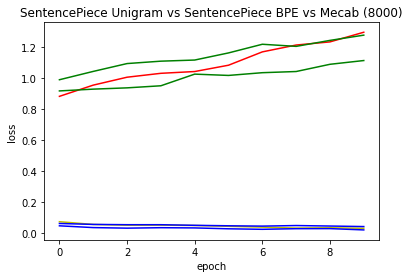

In [54]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history_model_1.history['loss'], 'y', label='train loss')
loss_ax.plot(history_model_1.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.plot(history_model_2.history['loss'], 'b', label='train loss')
loss_ax.plot(history_model_2.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.plot(history_model_3.history['loss'], 'b', label='train loss')
loss_ax.plot(history_model_3.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.title('SentencePiece Unigram vs SentencePiece BPE vs Mecab (8000)')
plt.show()

# 회고

첫 GoingDeeper NLP에 들어와서 뭔가 LMS 할 때보다 더 잘해보고 싶어서 시간을 써보려 했지만 기본적인 부분만 해봐서 아쉽고 16k, 32k 등의 모델이나 다른 모델의 경우를 좀 더 비교해봐야겠다고 생각했다.<br>
시각화도 그렇고 결과가 만족스럽지 않기에 이후에 다시 정리할 때 시도해봐야겠다.<br>
아직 코드 작성에 있어 부족한 면이 들고 깊게 하나하나 의미를 따져가고 기초를 정리해보면서 진행해야겠다고 생각이 들었다.